In [326]:
import numpy as np
import matplotlib.pyplot as plt
from cond_color import *

data = np.load(r'C:\Users\oconn\OneDrive\Desktop\psths_2.npz')
X, times = data['X'], data['times']

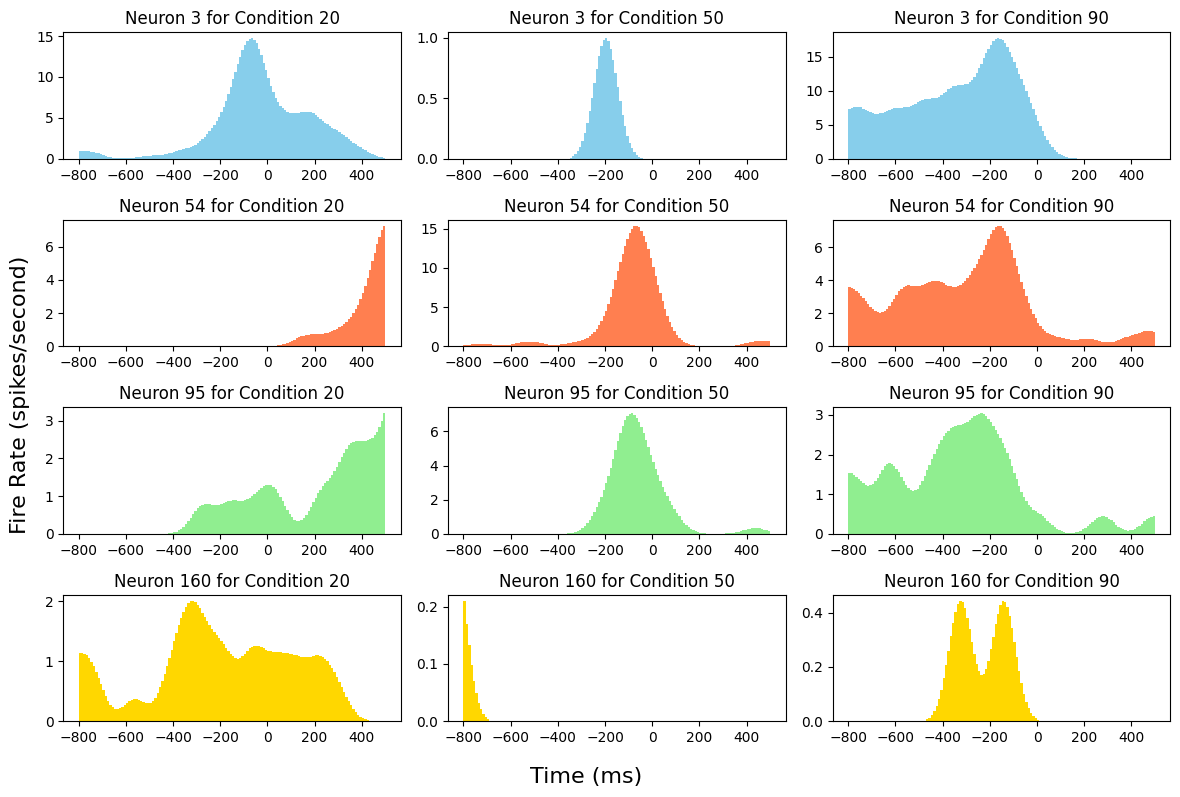

In [327]:
# pich a handful of neurons on a handful of conditions
neurons = [3, 54, 95, 160]
neuron_colours = ['skyblue', 'coral', 'lightgreen', 'gold']
conditions = [20, 50, 90]

# make a 3 x 4 subplot
fig, axes = plt.subplots(nrows=len(neurons), ncols=len(conditions), figsize=(12, 8))

for i in range(len(neurons)):
    for j in range(len(conditions)):
        bin_heights = X[i, j, :]        # heights for each bin

        axes[i, j].bar(times, bin_heights, width=10, align='edge', color=neuron_colours[i])
        axes[i, j].set_title(f'Neuron {neurons[i]} for Condition {conditions[j]}')

fig.supxlabel("Time (ms)", fontsize=16)
fig.supylabel("Fire Rate (spikes/second)", fontsize=16)
plt.tight_layout()
plt.savefig('PSTHs of Neurons')
plt.show()

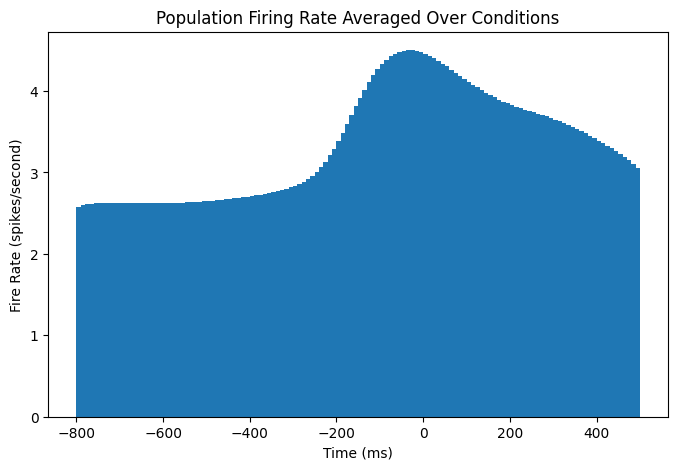

In [328]:
average_over_tasks = np.mean(X, axis=(0,1))

plt.figure(figsize=(8,5))
plt.bar(times, average_over_tasks, width=10, align='edge')
plt.xlabel('Time (ms)')
plt.ylabel('Fire Rate (spikes/second)')
plt.title('Population Firing Rate Averaged Over Conditions')
plt.savefig('Population firing rate')
plt.show()

## Preprocessing

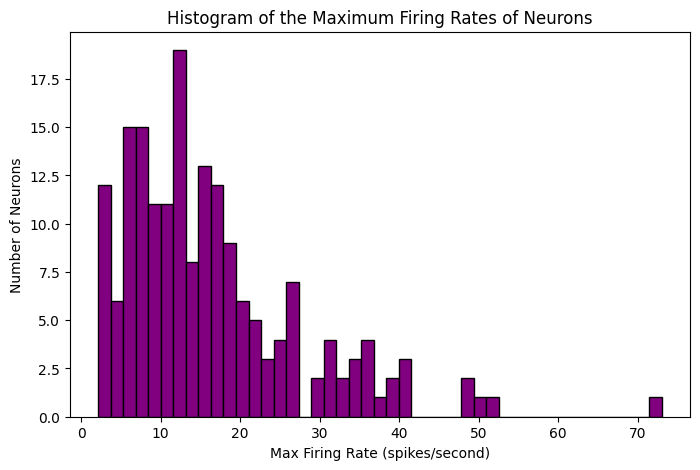

In [329]:
max_across_time = np.max(X, axis=(1,2))
max_across_time.shape

plt.figure(figsize=(8,5))
plt.hist(max_across_time, bins=45, edgecolor='black', color='purple')
plt.xlabel('Max Firing Rate (spikes/second)')
plt.ylabel('Number of Neurons')
plt.title('Histogram of the Maximum Firing Rates of Neurons')
plt.savefig('Histogram of max firing rates')
plt.show()

In [330]:
# for each neuron, find its max and min firing rate
X_processed = np.zeros(X.shape)

for i in range(182):
    a = np.max(X[i,:,:], axis=(0,1))
    b = np.min(X[i,:,:], axis=(0,1))
    X_processed[i, :, :] = (X[i,:,:] - b) * (1/(a-b+5))

# now remove the cross-conditioned mean
mean_over_conditions = np.mean(X, axis=(1))
X_processed = X_processed - mean_over_conditions[:, np.newaxis, :]

# now shorten the PSTH to only 46 bins around the onset of movement
X_processed_short = X_processed[:,:, 65:65+46]

# now reshape into a 182 x (108x46) array
X_processed_short = X_processed_short.reshape(182, 46*108)
X_processed_short.shape

(182, 4968)

Now do PCA

In [331]:
U, S, Vt = np.linalg.svd(X_processed_short)

M = 12          # take top 12 eigenvectors corresponding to top 12 eigenvalues

U_m = U[:, :M]      # take first 12 columns of U
S_m = S[:M]         # take top 12 singular values
Vt_m = Vt[:M, :]    # take first 12 rows of Vt

V_M = U_m @ np.diag(S_m)            # matrix where the columns are the principal components

V_M.shape

(182, 12)

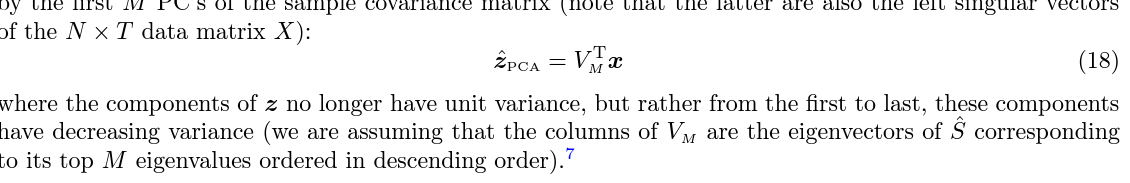

In [332]:
Z = V_M.T @ X_processed_short
Z.shape

(12, 4968)

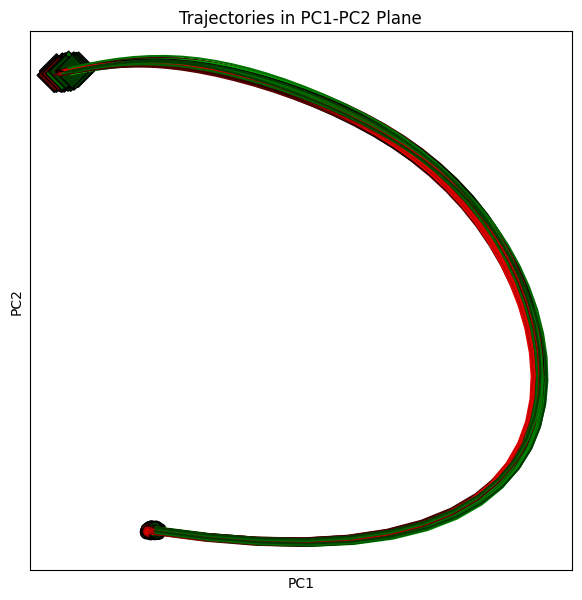

In [333]:
# reshape back into a 3D array for plotting
Z = Z.reshape(12, 108, 46)

colours = get_colors(Z[0, :, 0], Z[1, :, 0])

plt.figure(figsize=(7,7))

for i in range(108):
    PC1_trajectory = Z[0, i, :]
    PC2_trajectory = Z[1, i, :]
    plt.plot(PC1_trajectory, PC2_trajectory, '-', color=colours[i])

plot_start(Z[0, :, 0], Z[1, :, 0], colours, markersize=300)
plot_end(Z[0, :, -1], Z[1, :, -1], colours, markersize=300)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Trajectories in PC1-PC2 Plane')
plt.savefig('Trajectories in PC1-PC2 Plane')
plt.show()

In [334]:
delta_Z = np.diff(Z, n=1, axis=2)
delta_Z.shape                           # this gives the temporal matrix

# Z in the expression should denotes a slice of Z which has the shape 12, 108, 45
Z_dash = Z[:,:,1:]

# make into 2D arrays
Z_dash = Z_dash.reshape(12, 108*45)
delta_Z = delta_Z.reshape(12, 108*45)


(12, 108, 45)
(12, 108, 45)
(12, 4860)
(12, 4860)


In [335]:
def general_K(M):
    return int(0.5 * M * (M-1))

def make_H(M):
    K = general_K(M)
    H = np.zeros((K,M,M))
    k = 0
    for i in range(0,M-1):
        for j in range(i+1,M):
            H[k][i][j] = 1
            H[k][j][i] = -1
            k += 1
    return H

In [336]:
H = make_H(M=12)

W = np.tensordot(H, Z_dash, axes=1)

K, M, T_minus_1 = W.shape

# Reshape W to combine the M and C(T-1) dimensions for easier matrix multiplication
W_flat = W.reshape(K, -1)   # W_flat shape will be (K, M * C(T-1))

# Compute Q by taking the dot product of W_flat with its transpose
Q = np.dot(W_flat, W_flat.T)  # Resulting shape of Q will be (K, K)

# Compute b by broadcasting and summing over the appropriate axes
b = np.einsum('mn,kmn->k', delta_Z, W)

beta_ML = np.linalg.solve(Q, b)

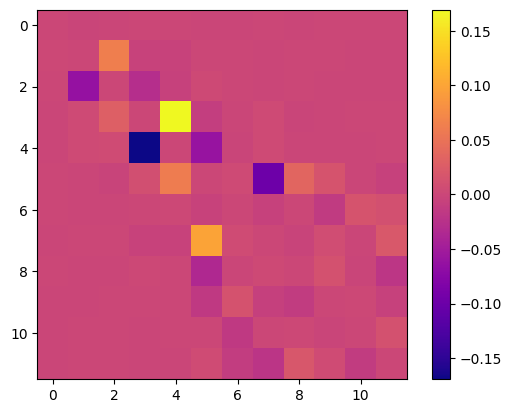

In [349]:
A_ML = np.tensordot(beta_ML, H, axes=1)

plt.imshow(A_ML, cmap='plasma')
plt.colorbar()
plt.savefig('A colour plot')
plt.show()

In [338]:
# function for estimating A which only receives Z as an input:
def estimate_A(Z):
    M, C, T = Z.shape
    K = general_K(M)

    delta_Z = np.diff(Z, n=1, axis=2)
    Z_dash = Z[:,:,1:]                  # make Z the same shape as deltaZ (time differences)

    # reshape into 2d arrays
    Z_dash = Z_dash.reshape(M, C*(T-1))
    delta_Z = delta_Z.reshape(M, C*(T-1))

    H = make_H(M)
    W = np.tensordot(H, Z_dash, axes=1)

    W_flat = W.reshape(K, -1)
    Q = np.dot(W_flat, W_flat.T)
    b = np.einsum('mn,kmn->k', delta_Z, W)
    beta_ML = np.linalg.solve(Q, b)
    
    A_ML = np.tensordot(beta_ML, H, axes=1)
    return A_ML

In [351]:
data = np.load(r"C:\Users\oconn\OneDrive\Desktop\BMI Coursework\test.npz")
Z_test, A_test = data['Z_test'], data['A_test']
A_estimated = estimate_A(Z_test)
absolute_differences = np.abs(A_estimated - A_test)

max_ab_diff = np.max(absolute_differences)
avg_ab_diff = np.mean(absolute_differences)

8.216290581918029e-05 2.02954646218623e-05


In [340]:
eigenvalues, eigenvectors = np.linalg.eig(A_ML)

max_value, max_index = 0, 0
for i in range(len(eigenvalues)):
    if eigenvalues[i].imag > max_value:
        max_value = eigenvalues[i].imag
        max_index = i
    
print(max_value, max_index)

e_vector = eigenvectors[max_index]
imaginary_vector = e_vector.imag / np.linalg.norm(e_vector.imag)
real_vector = e_vector.real / np.linalg.norm(e_vector.real)

P_FR = np.row_stack((imaginary_vector, real_vector))

# apply P to Z
projection_onto_FR_plan = P_FR @ Z.reshape(12, 108*46)

0.1861190059271881 0


C:\Users\oconn\AppData\Local\Temp\ipykernel_21964\2794308638.py:15: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  P_FR = np.row_stack((imaginary_vector, real_vector))


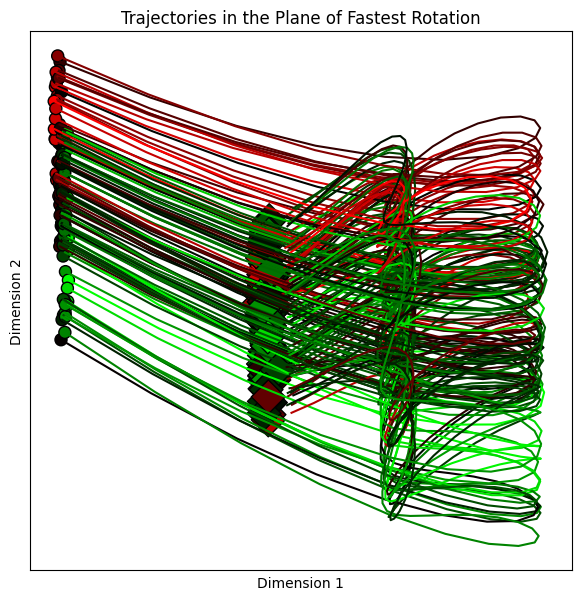

In [341]:
# reshape back to 3d
projection_onto_FR_plan = projection_onto_FR_plan.reshape(2,108,46)

colours = get_colors(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0])

plt.figure(figsize=(7,7))

for i in range(108):
    dim1_trajectory = projection_onto_FR_plan[0, i, :-10]
    dim2_trajectory = projection_onto_FR_plan[1, i, :-10]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours[i])

plot_start(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0], colours, markersize=300)
plot_end(projection_onto_FR_plan[0, :, -10], projection_onto_FR_plan[1, :, -10], colours, markersize=300)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Trajectories in the Plane of Fastest Rotation')
plt.savefig('Trajectories in the Plane of Fastest Rotation')
plt.show()


C:\Users\oconn\AppData\Local\Temp\ipykernel_21964\99191485.py:5: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  P_1 = np.row_stack((imaginary_vector, real_vector))


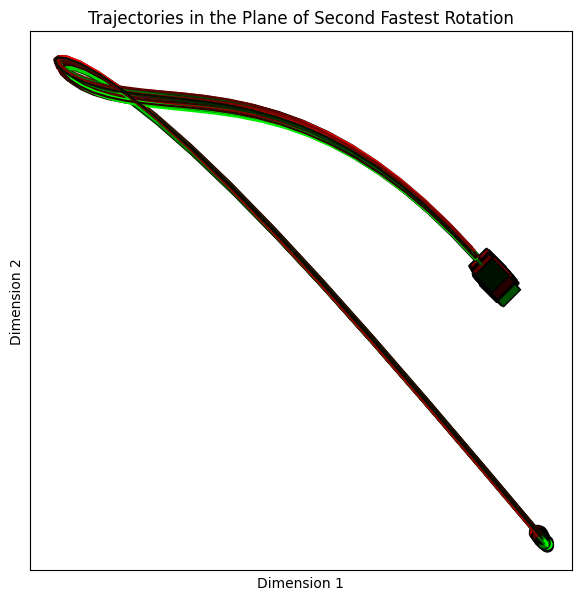

In [342]:
e_vector = eigenvectors[1]
imaginary_vector = e_vector.imag / np.linalg.norm(e_vector.imag)
real_vector = e_vector.real / np.linalg.norm(e_vector.real)

P_1 = np.row_stack((imaginary_vector, real_vector))

projection_onto_plane = P_1 @ Z.reshape(12, 108*46)
projection_onto_plane = projection_onto_plane.reshape(2,108,46)

colours = get_colors(projection_onto_plane[0, :, 0], projection_onto_plane[1, :, 0])

plt.figure(figsize=(7,7))

for i in range(108):
    dim1_trajectory = projection_onto_plane[0, i, :-10]
    dim2_trajectory = projection_onto_plane[1, i, :-10]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours[i])

plot_start(projection_onto_plane[0, :, 0], projection_onto_plane[1, :, 0], colours, markersize=300)
plot_end(projection_onto_plane[0, :, -10], projection_onto_plane[1, :, -10], colours, markersize=300)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Trajectories in the Plane of Second Fastest Rotation')
plt.savefig('Trajectories in the Plane of Second Fastest Rotation')
plt.show()

C:\Users\oconn\AppData\Local\Temp\ipykernel_21964\2594691907.py:5: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  P_1 = np.row_stack((imaginary_vector, real_vector))


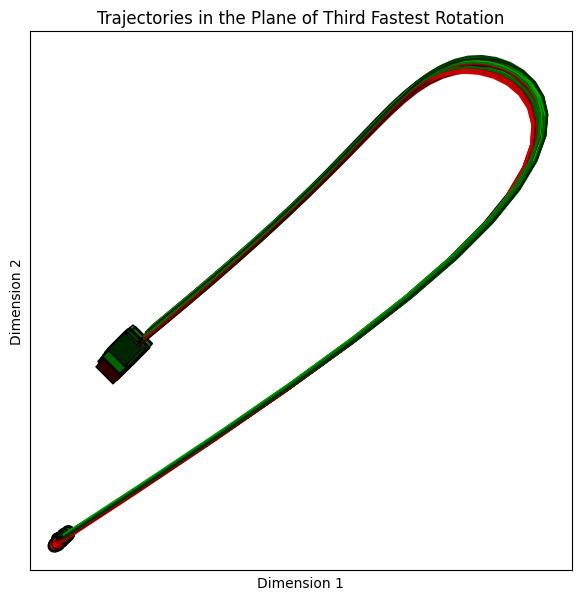

In [343]:
e_vector = eigenvectors[2]
imaginary_vector = e_vector.imag / np.linalg.norm(e_vector.imag)
real_vector = e_vector.real / np.linalg.norm(e_vector.real)

P_1 = np.row_stack((imaginary_vector, real_vector))

projection_onto_plane = P_1 @ Z.reshape(12, 108*46)
projection_onto_plane = projection_onto_plane.reshape(2,108,46)

colours = get_colors(projection_onto_plane[0, :, 0], projection_onto_plane[1, :, 0])

plt.figure(figsize=(7,7))

for i in range(108):
    dim1_trajectory = projection_onto_plane[0, i, :-10]
    dim2_trajectory = projection_onto_plane[1, i, :-10]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours[i])

plot_start(projection_onto_plane[0, :, 0], projection_onto_plane[1, :, 0], colours, markersize=300)
plot_end(projection_onto_plane[0, :, -10], projection_onto_plane[1, :, -10], colours, markersize=300)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Trajectories in the Plane of Third Fastest Rotation')
plt.savefig('Trajectories in the Plane of Third Fastest Rotation')
plt.show()

In [344]:
proj_matrix = P_FR @ V_M.T

# only do from -800 to -150
X_processed_short = X_processed[:,:,:66]

projection_onto_plane = proj_matrix @ X_processed_short.reshape(182, 108*66)
projection_onto_plane = projection_onto_plane.reshape(2,108,66)

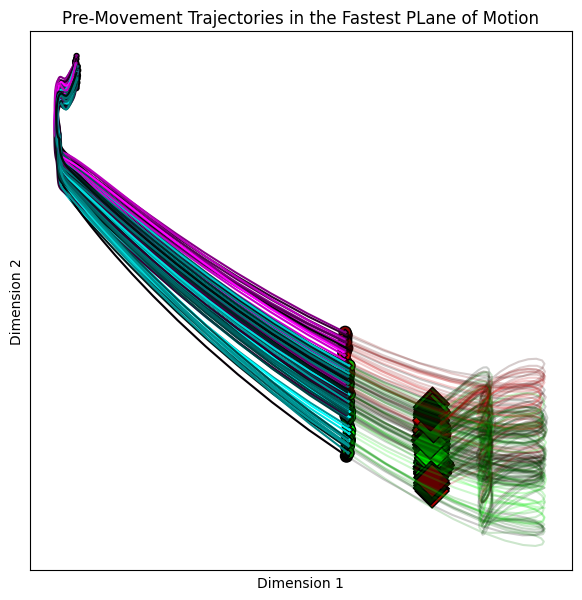

In [345]:
colours1 = get_colors(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0])
colours2 = get_colors(projection_onto_plane[0, :, -1], projection_onto_plane[1, :, -1], alt_colors=True)

plt.figure(figsize=(7,7))

for i in range(108):
    dim1_trajectory = projection_onto_FR_plan[0, i, :-10]
    dim2_trajectory = projection_onto_FR_plan[1, i, :-10]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours1[i], alpha=0.2)

for i in range(108):
    dim1_trajectory = projection_onto_plane[0, i, :]
    dim2_trajectory = projection_onto_plane[1, i, :]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours2[i])

plot_start(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0], colours1, markersize=300)
plot_end(projection_onto_FR_plan[0, :, -10], projection_onto_FR_plan[1, :, -10], colours1, markersize=300)

plot_start(projection_onto_plane[0, :, 0], projection_onto_plane[1, :, 0], colours2, markersize=50)
plot_end(projection_onto_plane[0, :, -1], projection_onto_plane[1, :, -1], colours2, markersize=10)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Pre-Movement Trajectories in the Fastest PLane of Motion')
plt.savefig('Pre-Movement Trajectories in the Fastest PLane of Motion')
plt.show()

In [346]:
X_distorted = X

# time for -150 ms is at index 65
t0 = 65
T = 46+t0      # length of movement portion

for i in range(182):        # for each neuron
    condition_indices = np.random.choice(108, (108//2,), replace=False)
    for j in condition_indices:
        X_distorted[i, j, t0:T] = 2 * X_distorted[i, j, t0] - X_distorted[i, j, t0:T]

X_distorted.shape

(182, 108, 130)

In [347]:
# for each neuron, find its max and min firing rate
X_processed = np.zeros(X_distorted.shape)

for i in range(182):
    a = np.max(X[i,:,:], axis=(0,1))
    b = np.min(X[i,:,:], axis=(0,1))
    X_processed[i, :, :] = (X[i,:,:] - b) * (1/(a-b+5))

# now remove the cross-conditioned mean
mean_over_conditions = np.mean(X, axis=(1))
X_processed = X_processed - mean_over_conditions[:, np.newaxis, :]

# now shorten the PSTH to only 46 bins around the onset of movement
X_processed_short = X_processed[:,:, 65:65+46]

# now reshape into a 182 x (108x46) array
X_processed_short = X_processed_short.reshape(182, 46*108)

U, S, Vt = np.linalg.svd(X_processed_short)

M = 12          # take top 12 eigenvectors corresponding to top 12 eigenvalues

U_m = U[:, :M]      # take first 12 columns of U
S_m = S[:M]         # take top 12 singular values
Vt_m = Vt[:M, :]    # take first 12 rows of Vt

V_M = U_m @ np.diag(S_m)            # matrix where the columns are the principal components
Z = V_M.T @ X_processed_short

# reshape back into a 3D array for plotting
Z = Z.reshape(12, 108, 46)

0.13929350905599508 0


C:\Users\oconn\AppData\Local\Temp\ipykernel_21964\1386149493.py:17: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  P_FR = np.row_stack((imaginary_vector, real_vector))


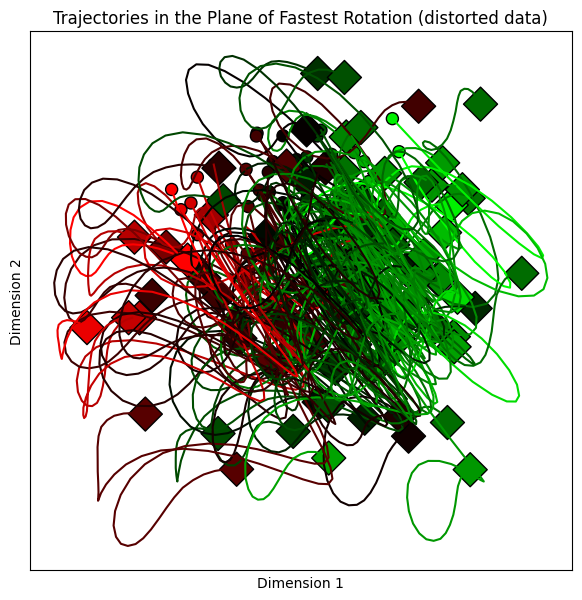

In [348]:
A_ML = estimate_A(Z)

eigenvalues, eigenvectors = np.linalg.eig(A_ML)

max_value, max_index = 0, 0
for i in range(len(eigenvalues)):
    if eigenvalues[i].imag > max_value:
        max_value = eigenvalues[i].imag
        max_index = i
    
print(max_value, max_index)

e_vector = eigenvectors[max_index]
imaginary_vector = e_vector.imag / np.linalg.norm(e_vector.imag)
real_vector = e_vector.real / np.linalg.norm(e_vector.real)

P_FR = np.row_stack((imaginary_vector, real_vector))

# apply P to Z
projection_onto_FR_plan = P_FR @ Z.reshape(12, 108*46)

# reshape back to 3d
projection_onto_FR_plan = projection_onto_FR_plan.reshape(2,108,46)

colours = get_colors(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0])

plt.figure(figsize=(7,7))

for i in range(108):
    dim1_trajectory = projection_onto_FR_plan[0, i, :-10]
    dim2_trajectory = projection_onto_FR_plan[1, i, :-10]
    plt.plot(dim1_trajectory, dim2_trajectory, '-', color=colours[i])

plot_start(projection_onto_FR_plan[0, :, 0], projection_onto_FR_plan[1, :, 0], colours, markersize=300)
plot_end(projection_onto_FR_plan[0, :, -10], projection_onto_FR_plan[1, :, -10], colours, markersize=300)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Trajectories in the Plane of Fastest Rotation (distorted data)')
plt.savefig('Trajectories in the Plane of Fastest Rotation (distorted data)')
plt.show()